In [1]:
from PIL import Image
import numpy as np


In [2]:
import time
start = time.time()


FLAGS


In [3]:
filename="arbabcat"
ext="jpg"

blocks getting function


In [4]:
def getblocks(image: np.ndarray, blockshape: tuple, moveAxis: bool = True, info: bool = False, addChannel: bool = True) -> np.ndarray:
    '''
    takes the array of image in grey= 2D and in RGB = 3D
    takes the numpy array and converts it the the blocks in the fastest way
    '''
    if(info):
        print("Image Shape:", image.shape)
        print("Block Shape:", blockshape)

    oldshape = list(image.shape)
    if addChannel and len(image.shape) == 2:
        mode = "grey"
        image = image.reshape((*image.shape, 1))
    else:
        mode = "color"

    if addChannel:
        img_height, img_width, channels = image.shape
    else:
        img_height, img_width = image.shape

    tile_height, tile_width = blockshape

    if addChannel:
        shp = img_height//tile_height, tile_height, img_width//tile_width, tile_width, channels
    else:
        shp = img_height//tile_height, tile_height, img_width//tile_width, tile_width

    def printinfo():
        print("Old Shape:", oldshape)
        print("Image Shape:", image.shape)
        print("Block Shape:", blockshape)
        print("New Shape Initial:", shp)
        print("img_height % tile_height != 0 :", img_height % tile_height != 0)
        print("img_width % tile_width != 0 :", img_width % tile_width != 0)

    if img_height % tile_height != 0 or img_width % tile_width != 0:
        print("warning: Block size is not fit for the image!")
        printinfo()

    if(info):
        printinfo()

    tiled_array = image.reshape(shp)
    tiled_array = tiled_array.swapaxes(1, 2)

    if moveAxis:
        if(addChannel):
            tiled_array = tiled_array.reshape(-1,
                                              *(tile_height, tile_width, channels))
            tiled_array = np.moveaxis(tiled_array, source=len(
                tiled_array.shape)-1, destination=1)
        else:
            tiled_array = tiled_array.reshape(-1, *(tile_height, tile_width))

    return tiled_array


In [5]:
def combineBlocks(tiled_array: np.ndarray, imageshape: tuple, blockshape: tuple, movedAxis: bool = True, channel: bool = True) -> np.ndarray:

    if channel:
        if len(imageshape) == 2:
            mode = "grey"
            imageshape = *imageshape, 1
        else:
            mode = "color"

    if channel:
        img_height, img_width, channels = imageshape
    else:
        img_height, img_width = imageshape

    tile_height, tile_width = blockshape

    if movedAxis:
        image = tiled_array.copy()
        if(channel):
            image = image.reshape(img_height//tile_height, tile_height,
                                  img_width//tile_width, tile_width, channels)
            swapaxisShape = list(image.shape)
            swapaxisShape[1], swapaxisShape[2] = swapaxisShape[2], swapaxisShape[1]
            image = image.reshape(swapaxisShape)
            image = image.swapaxes(1, 2)
        else:
            f = image.reshape(img_height//tile_height, tile_height,
                              img_width//tile_width, tile_width)
            swapaxisShape = list(f.shape)
            swapaxisShape[1], swapaxisShape[2] = swapaxisShape[2], swapaxisShape[1]
            tmp = f.reshape(swapaxisShape)
            image = tmp.swapaxes(1, 2)
    else:
        image = tiled_array
        # I haven't completed this else case. Btw we aren't using this case lol :)

    return image.reshape(imageshape)


In [6]:
def printnd(arr: np.ndarray):
    print("Shape:", arr.shape)
    print("Strides:", arr.strides)
    print(arr)


PSNR function


In [7]:
from math import log10, sqrt


In [8]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
        # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


importing image
e.g lena which is 512x512
importing as the grey image denoted by L flag


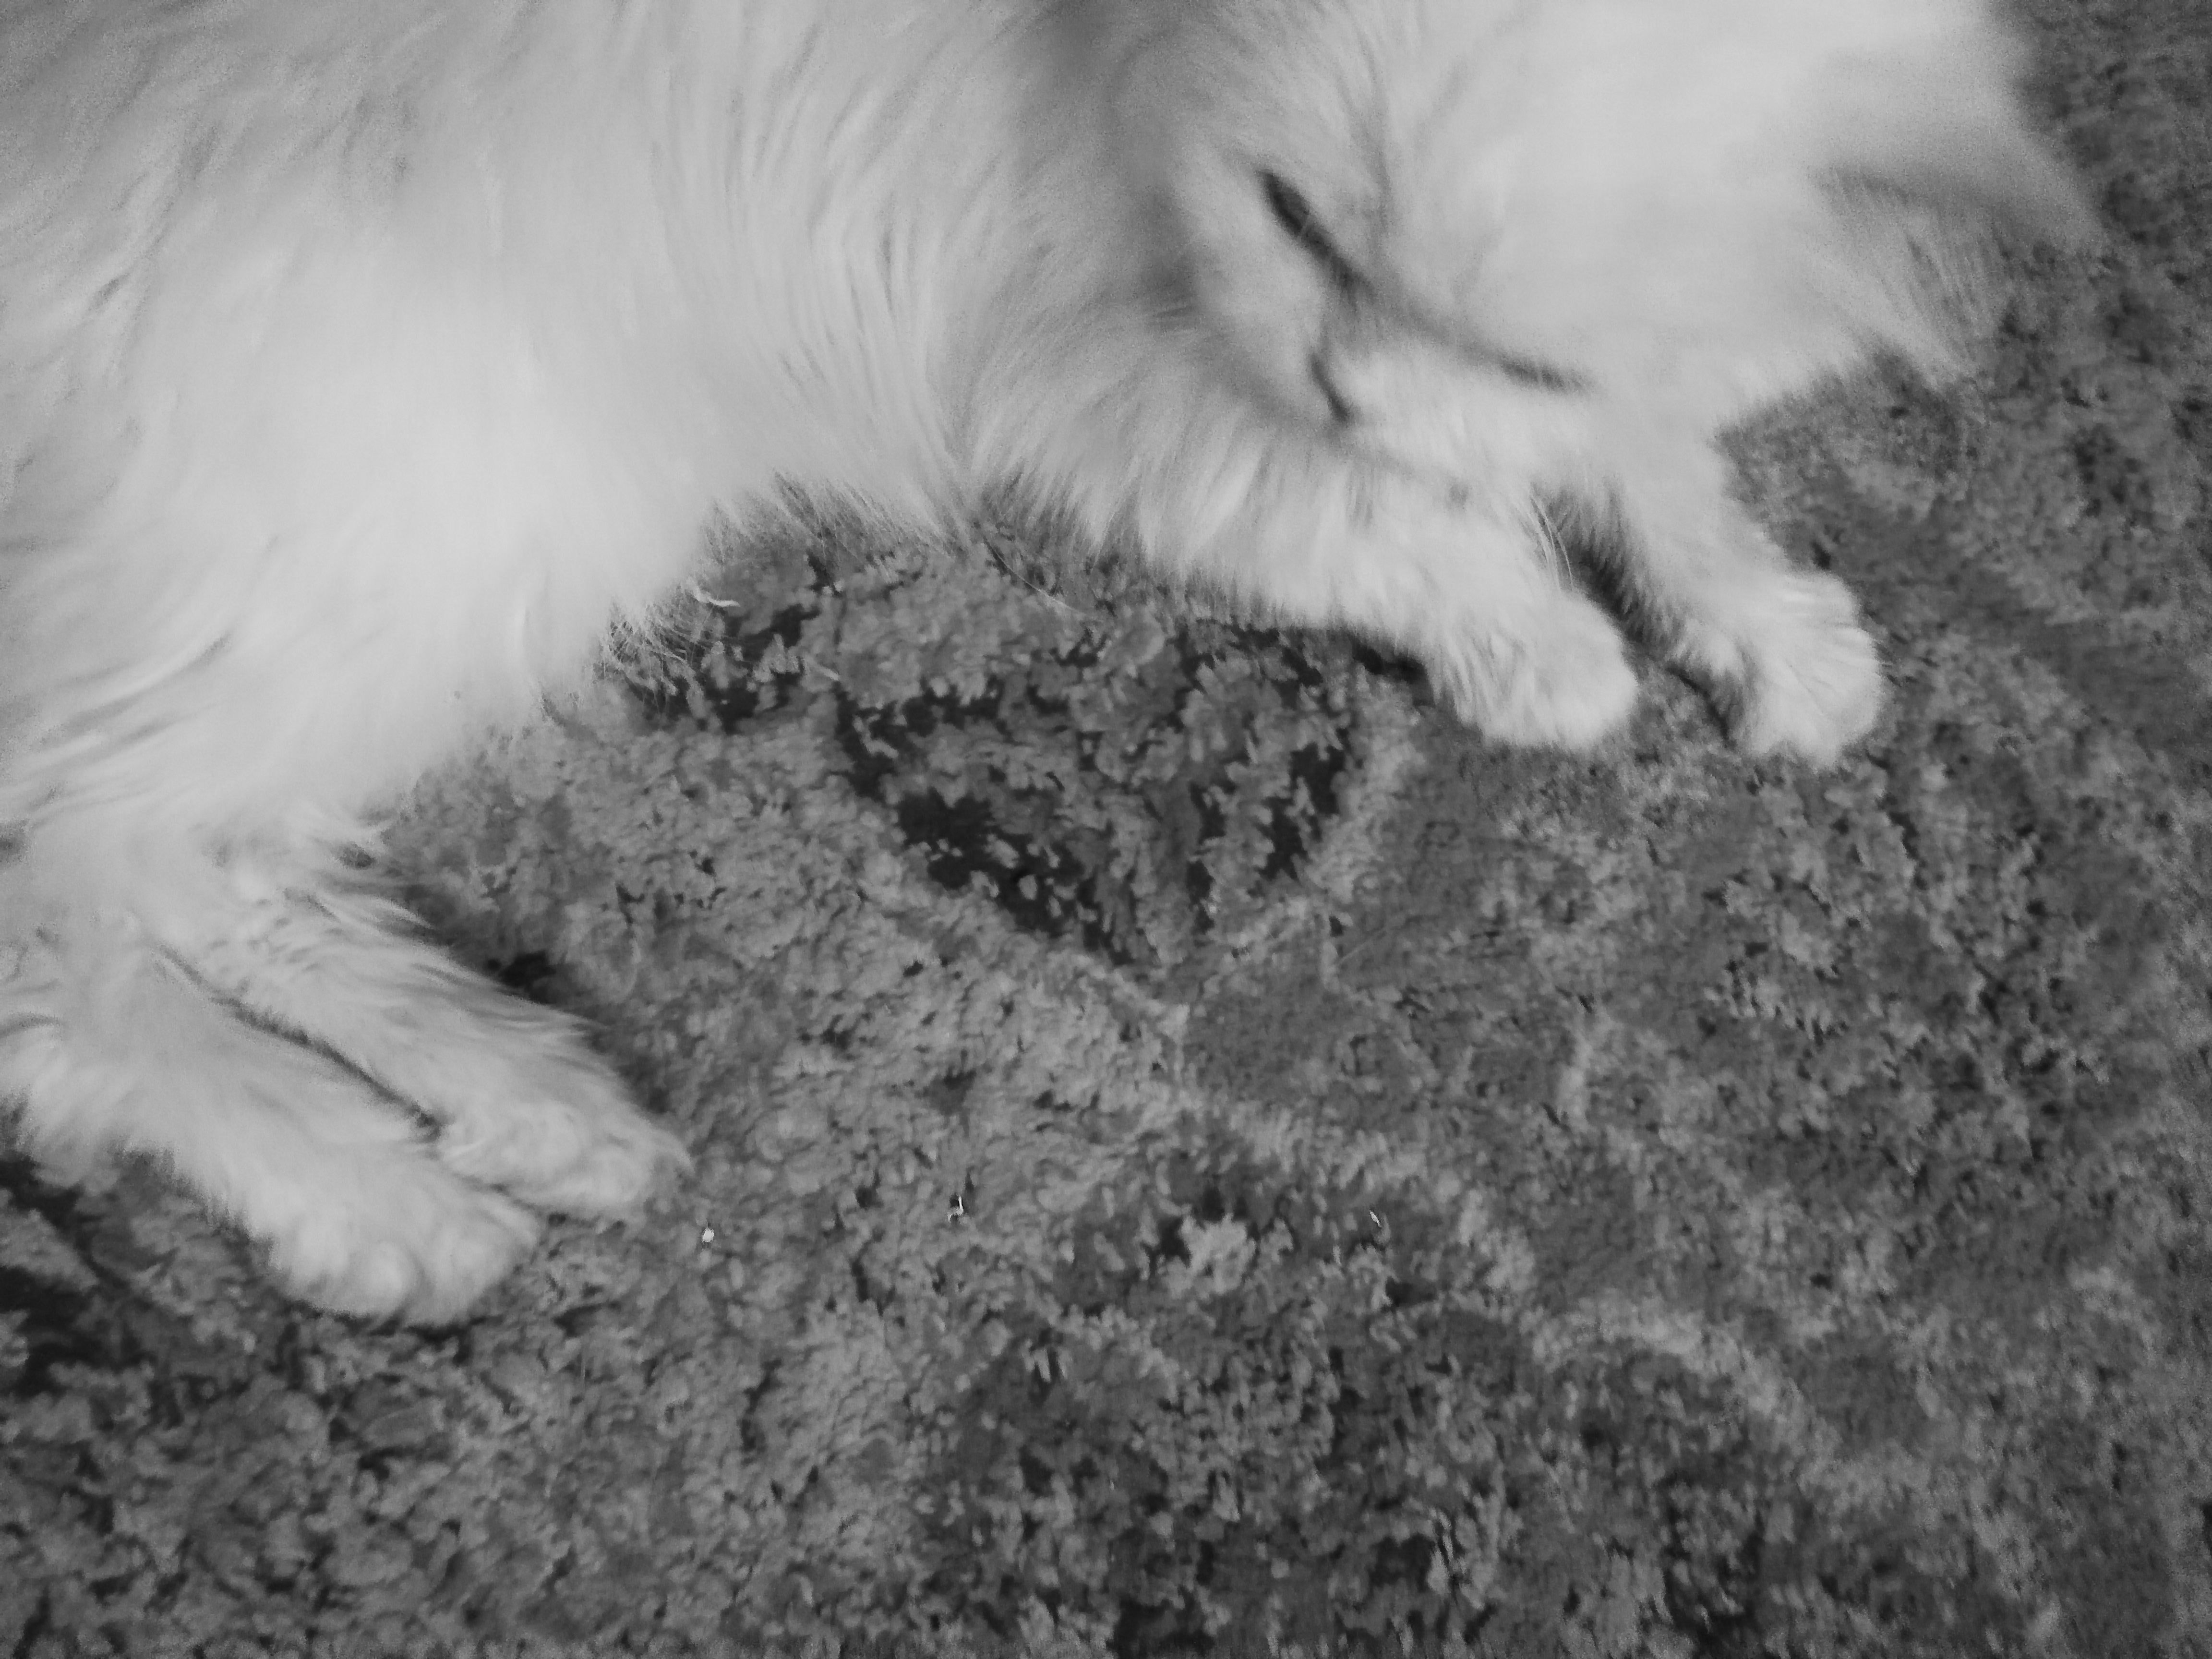

In [9]:
lena = Image.open(f"{filename}.{ext}").convert("L")
lena
# lena = Image.open("fyp_image.JPG").convert("L")
# lena


converting to np array


In [10]:
img = np.array(lena)
imgSize = img.shape
M, N = img.shape
img.shape, img.strides, img


((3456, 4608),
 (4608, 1),
 array([[122, 120, 120, ...,  90,  89,  88],
        [121, 119, 118, ...,  92,  92,  88],
        [120, 119, 116, ...,  93,  94,  88],
        ...,
        [ 73,  75,  78, ...,  81,  84,  86],
        [ 72,  73,  75, ...,  84,  85,  83],
        [ 67,  67,  68, ...,  86,  85,  80]], dtype=uint8))

In [11]:
if imgSize[0] % 64 != 0 or imgSize[1] % 64 != 0:
    raise Exception("Size not correct for embedding")


making 16 main blocks
size of single main block S= M/sqrt(16) X T=N/sqrt(16)
e.g for lena the 512x512 the partner blocks size would be 16 blocks each with size (512x512)/(4x4) = 128x128


In [12]:
mainblockSize = (int(imgSize[0]/4), int(imgSize[1]/4))
mainblocks = getblocks(img.copy(), mainblockSize, info=True)
mainblocks.shape, mainblocks.strides, mainblocks


Image Shape: (3456, 4608)
Block Shape: (864, 1152)
Old Shape: [3456, 4608]
Image Shape: (3456, 4608, 1)
Block Shape: (864, 1152)
New Shape Initial: (4, 864, 4, 1152, 1)
img_height % tile_height != 0 : False
img_width % tile_width != 0 : False


((16, 1, 864, 1152),
 (995328, 1, 1152, 1),
 array([[[[122, 120, 120, ..., 169, 171, 173],
          [121, 119, 118, ..., 170, 172, 173],
          [120, 119, 116, ..., 172, 172, 171],
          ...,
          [165, 166, 167, ..., 204, 204, 204],
          [167, 166, 167, ..., 204, 204, 205],
          [168, 167, 165, ..., 204, 204, 205]]],
 
 
        [[[173, 174, 173, ..., 112, 111, 112],
          [173, 174, 173, ..., 111, 111, 111],
          [171, 172, 172, ..., 109, 107, 107],
          ...,
          [205, 205, 205, ..., 154, 154, 155],
          [204, 204, 204, ..., 156, 157, 159],
          [204, 203, 203, ..., 158, 158, 159]]],
 
 
        [[[112, 113, 111, ..., 199, 200, 201],
          [112, 113, 112, ..., 200, 200, 201],
          [107, 112, 112, ..., 200, 201, 201],
          ...,
          [155, 153, 155, ..., 182, 181, 181],
          [155, 154, 155, ..., 181, 181, 182],
          [158, 156, 155, ..., 181, 180, 181]]],
 
 
        ...,
 
 
        [[[123, 117, 112, ...,

here the main blocks are like this index.
1st index is the block number.
2nd index is the channel (RGB) or 0 in Grey.
3rd and 4th are for indexing the block.


converting back and checking


lookup table


In [13]:
lookup = np.array([[0, 7, 13, 10],
                  [1, 6, 12, 11],
                  [4, 2, 9, 15],
                  [5, 3, 8, 14]], dtype=np.uint8)
lookup


array([[ 0,  7, 13, 10],
       [ 1,  6, 12, 11],
       [ 4,  2,  9, 15],
       [ 5,  3,  8, 14]], dtype=uint8)

here the every row represents the partner blocks
e.g
A1 will be lookup[0][0].
A2 will be lookup[0][2].
D2 will be lookup[3][2].


Step3
Ab har main block ko divide karo k 4x4 k block ban jain
numberOfBlocks=(SxT)/(4x4)
e.g 128x128/4x4 = 1024


In [14]:
avgblocksSize = (4, 4)
averages = np.zeros((16, int((mainblockSize[0]*mainblockSize[1]) /
                             (avgblocksSize[0]*avgblocksSize[1]))), dtype=np.uint8)
# 4 indicatior A,B,C,D, 4 blocks of A, then the 4x4 Blocks which have count = (SxT)/(4x4), e.g 1024


storing the averages of A, B, C, D


In [15]:
for partner in lookup:  # A,B,C,D
    for id in partner:  # A1,A2,A3.....D4 etc
        averages[id] = getblocks(mainblocks[id][0].copy(), avgblocksSize,
                                 info=False, addChannel=False).mean((1, 2))


array([[162, 162, 162, 161],
       [162, 162, 162, 161],
       [162, 162, 162, 161],
       [162, 162, 162, 161]], dtype=uint8)
this will give you the avg 161. But it sould be 162 as it's dominant. Minor improvemnt reuqired


now we have average of every mainblock according to 4x4. Which in total are 1024


time to convert them into the binary


In [16]:
averageBits = np.unpackbits(averages, axis=1)
# averageBits.shape, averageBits


merging partner blocks average to make the recovery bits


In [17]:
recoveryBits = np.zeros(
    (averageBits.shape[0], averageBits.shape[1]*3), dtype=np.uint8)
for partner in lookup:  # A,B,C,D
    for id in partner:  # A1,A2,A3.....D4 etc
        recoveryBits[id] = np.concatenate(
            [averageBits[i] for i in partner if i != id])

# recoveryBits.shape, recoveryBits


password or key generation


In [18]:
import hashlib


In [19]:
# password or key
password = "this is my password"
key = [x for x in hashlib.sha256(password.encode()).digest()]
# len(key)


permuttaion or shuffling


In [20]:
for i in range(recoveryBits.shape[0]):
    np.random.RandomState(seed=key).shuffle(recoveryBits[i])

# recoveryBits.shape, recoveryBits


Recovery bits creation completed
Now we need to make the space to put these recovery bits


### Making 16x16 for Step 8

Dividing the main blocks to 16x16 blocks
Total blocks = SxT/16x16 = 128x128/16x16 = 64 Blocks


In [21]:
mainblocks.shape


(16, 1, 864, 1152)

In [22]:
blocks16x16Size = (16, 16)
# reshaping because we needed that shape
blocks16x16 = mainblocks.copy().reshape(
    *mainblocks.shape[:-2],
    int((mainblockSize[0]*mainblockSize[1]) /
        (blocks16x16Size[0]*blocks16x16Size[1])),
    blocks16x16Size[0], blocks16x16Size[1]).copy()

# blocks16x16Size, blocks16x16.shape, blocks16x16.strides, blocks16x16


In [23]:
for i in range(mainblocks.shape[0]):
    blocks16x16[i][0] = getblocks(mainblocks[i][0].copy(), blocks16x16Size,
                                  info=False, addChannel=False)

# blocks16x16.shape, blocks16x16.strides, blocks16x16


combinign for checking


### Making 8x8 blocks of those 16x16 Step 9


In [24]:
blocks8x8Size = (8, 8)
# reshaping because we needed that shape
blocks8x8 = blocks16x16.copy().reshape(
    *blocks16x16.shape[:-2],
    int((blocks16x16Size[0]*blocks16x16Size[1]) /
        (blocks8x8Size[0]*blocks8x8Size[1])),
    blocks8x8Size[0], blocks8x8Size[1])

# blocks8x8Size, blocks8x8.shape, blocks8x8.strides, blocks8x8


In [25]:
for i in range(blocks16x16.shape[0]):
    for j in range(blocks16x16.shape[2]):
        blocks8x8[i][0][j] = getblocks(blocks16x16[i][0][j].copy(), blocks8x8Size,
                                       info=False, addChannel=False)

# blocks8x8.shape, blocks8x8.strides, blocks8x8


combining and checking


Now put the recovery bit in the first and second LSB of blocks4x4


In [26]:
recoveryBits.reshape(recoveryBits.shape[0], int(
    recoveryBits.shape[1]//2), 2).shape


(16, 746496, 2)

updating the lsb


In [27]:
def set_bit(value, index, x):
    # """Set the index:th bit of v to 1 if x is truthy, else to 0, and return the new value."""
    # mask = 1 << index   # Compute mask, an integer with just bit 'index' set.
    # # Clear the bit indicated by the mask (if x is False)
    # value &= ~mask
    # if x:
    #     # If x was True, set the bit indicated by the mask.
    #     value |= mask
    # return value            # Return the result, we're done.
    def set_bit2(value, bit):
        return value | (1 << bit)

    def clear_bit(value, bit):
        return value & ~(1 << bit)

    if x:
        return set_bit2(value, index)
    else:
        return clear_bit(value, index)


def get_bit(value, index):
    if value & (1 << index):
        return True
    else:
        return False


In [28]:
set_bit(2, 3, 0), set_bit(2, 2, 1)
#(0, 6)


(2, 6)

In [37]:
bits = recoveryBits.reshape(
    recoveryBits.shape[0], int(recoveryBits.shape[1]//2), 2)

In [30]:
blocks8x8[i, 0, :, :3, :, :].shape

(3888, 3, 8, 8)

In [31]:
3888*3*8*8

746496

In [40]:
ii=0
jj=0
def change(number):
  number=set_bit( set_bit(number, 0, bits[ii][jj][0]), 1, bits[ii][jj][1])
  if jj%746496==0:
    ii+=1
    jj=0
  else:
    jj+=1

In [41]:
np.apply_along_axis(change, 0, blocks8x8[i, 0, :, :3, :, :].flat)

UnboundLocalError: local variable 'ii' referenced before assignment

In [ ]:

for i in range(blocks8x8[:, 0].shape[0]):
    for j in range(len(blocks8x8[i, 0, :, :3, :, :].flat)):
        number = blocks8x8[i, 0, :, :3, :, :].flat[j]
        blocks8x8[i, 0, :, :3, :, :].flat[j] = set_bit(
            set_bit(number, 0, bits[i][j][0]), 1, bits[i][j][1])

# for mainblock, blockbits in zip(blocks8x8[:, 0, :, :3, :, :], recoveryBits.reshape(recoveryBits.shape[0], int(recoveryBits.shape[1]//2), 2)):
#     for number, bits in zip(mainblock.flat, blockbits):
#         # print(number, bits)
#         number = set_bit(set_bit(number, 0, bits[0]), 1, bits[1])


# blocks8x8.shape, blocks8x8.strides, blocks8x8


### get authenticaction bits


getting hash of four blocks with lsb 0


so we have the space of 128bit for hashing
we want to add the size of image + the blocknumber of eachblock
size will be multiple of 64
1byte of length, max length = 64*256=16384
1byte of width, max width = 64*256=16384
the remaing length for hash is now 112
for block number I'm excluding the 4 bits and 4bits will be reserved for the lookuptable
the make the total bits=104, that make 104/8=13bytes
we are using dynamic hasing algo (blake2b) with digest size 13bytes


In [ ]:
HASH_SIZE = 16


In [ ]:
def set_lsb_zero(num: np.ndarray):
    '''
    Clearing the first two LSB of ndarray
    '''
    return set_bit(set_bit(num, 0, 0), 1, 0)


'''
Data is one 16x16 block converted into four 8x8 blocks
'''


def hash_block(data: np.ndarray, key: str = None, digest_size=HASH_SIZE, extras=[]):
    if data.shape != (4, 8, 8):
        print(f"Warning! given size {data.shape} instead of (4, 8, 8)")
    local = data.copy().astype(np.int8)  # copying to avoid overighting lsb
    local[-1] = set_lsb_zero(local[-1])  # setting last 8x8 blocks lsb zero
    if key is None:
        h = hashlib.blake2b(digest_size=digest_size)
    else:
        h = hashlib.blake2b(key=key.encode())
    h.update(local.data)
    for extra in extras:
        h.update(extra.encode())
    return h


def put_bits(data: np.ndarray, bits: np.ndarray):
    '''
    puts data in last two lsb of data
    '''
    if data.shape != (8, 8):
        print(f"Warning! given size {data.shape} instead of (8, 8)")
    if bits.shape != (64, 2):
        print(f"Warning! given size {bits.shape} instead of (64, 2)")
    localData = data.copy().reshape(-1)
    localBits = bits.copy()
    '''
    setting last two lsb of data to bits
    '''
    localData = np.fromiter((set_bit(set_bit(d, 0, b[0]), 1, b[1]) for d, b in zip(
        localData, localBits)), dtype=data.dtype)

    return localData.reshape(8, 8)


def get_bits(data: np.ndarray):
    '''
    gets data from last two lsb of data
    '''
    if data.shape != (8, 8):
        print(f"Warning! given size {data.shape} instead of (8, 8)")
    localData = data.copy()
    bits = np.zeros((64, 2), np.uint8)
    bits[:, 0] = np.fromiter((get_bit(d, 0)
                             for d in localData.flat), dtype=np.uint8)
    bits[:, 1] = np.fromiter((get_bit(d, 1)
                             for d in localData.flat), dtype=np.uint8)
    return bits


In [ ]:
hashes = np.zeros((*blocks8x8[:, 0].shape[:2], HASH_SIZE*8), dtype=object)
# hashes.shape, hashes


In [ ]:
def hexToDec(hexStr):
    return np.fromiter((int(x, 16) for x in hexStr), dtype=np.uint8)


def binToNp(binStr):
    return np.frombuffer(binStr, dtype=np.uint8)


# has = hash_block(blocks8x8[0, 0, 1])

# print(has, has.hexdigest(), len(has.digest()))
# dec = binToNp(has.digest())
# dec.shape, dec


In [ ]:
# binToNp(b'\x')


In [ ]:
# hashes[0]='ashdadka'
# hashes


In [ ]:
# type(hashlib.sha256("basd".encode()).hexdigest())


In [ ]:
# hash_block(blocks8x8[0, 0, 0], digest_size=32)


In [ ]:
# temp=hash_block(
#             blocks8x8[0, 0, 0])
# x=temp.digest()
# temp.hexdigest(), binToNp(temp.digest()), x, type(x), x.hex(), x[0], x[1].to_bytes(8, byteorder='big').hex()


so there are four block of 8x8
8x8 block has (2bits) _ 8 _ 8=128bit space


In [ ]:
for i in range(blocks8x8[:, 0].shape[0]):
    for j in range(blocks8x8[:, 0].shape[1]):
        hashes[i][j] = np.unpackbits(binToNp(hash_block(
            blocks8x8[i, 0, j]).digest()))


# hashes.shape, hashes[0][0], hashes


#### now we have to put this hash in the 4th 8x8 block of eaxh 16x16block :)


In [ ]:
# reshaping it into 2bits in last for better placement
hashbits = hashes.reshape(
    hashes.shape[0], hashes.shape[1], hashes.shape[2]//2, 2)
# hashbits.shape


not the best approach
will do it like we did with recoverybits

In [ ]:
for i in range(blocks8x8[:, 0].shape[0]):
    for j in range(blocks8x8[:, 0].shape[1]):
        blocks8x8[i, 0, j, 3, :, :]=put_bits(blocks8x8[i, 0, j, 3, :, :], hashbits[i, j])

# blocks8x8.shape, blocks8x8.strides, blocks8x8


### Now to combine the blocks back to Image


first merge the 8x8


In [ ]:
combined16x16 = blocks16x16.copy()


In [ ]:
for i in range(combined16x16.shape[0]):
    for j in range(combined16x16.shape[2]):
        combined16x16[i][0][j] = combineBlocks(blocks8x8[i][0][j].copy(), imageshape=(
            16, 16), blockshape=(8, 8), channel=False)
# combined16x16.shape, combined16x16.strides, combined16x16


merging 16x16 to 128x128


In [ ]:
combinedMainBlocks = mainblocks.copy()


In [ ]:
for i in range(combinedMainBlocks.shape[0]):
    combinedMainBlocks[i][0] = combineBlocks(
        combined16x16[i][0], mainblockSize, blockshape=(16, 16), channel=False)

# combinedMainBlocks.shape, combinedMainBlocks


In [ ]:
combinedImg = combineBlocks(combinedMainBlocks.copy(), imgSize, mainblockSize)
combinedImg.shape, combinedImg
combinedImg = combinedImg.reshape(imgSize)
combinedImg.shape, combinedImg


combining to the image


In [ ]:
Image.fromarray(combinedImg, 'L')


In [ ]:
PSNR(img, combinedImg)


In [ ]:
done = time.time()
elapsed = done - start


In [ ]:
print(elapsed)

In [ ]:
imgSize

In [ ]:
raise Exception('stop')

In [ ]:
print("This time includes all the unnessary outputs and checks")
elapsed


In [ ]:
# saving to file
Image.fromarray(combinedImg, 'L').save(f"{filename}_watermarked.png")


In [ ]:
# checking the saved file
lena = Image.open(f"{filename}_watermarked.png").convert("L")
img = np.array(lena)


In [ ]:
(img == combinedImg).all()


# Auth

In [ ]:
extractedHashes = np.zeros(hashbits.shape, dtype=hashbits.dtype)
extractedHashes.shape, extractedHashes


In [ ]:
for i in range(blocks8x8[:, 0].shape[0]):
    for j in range(blocks8x8[:, 0].shape[1]):
        number = blocks8x8[i, 0, :, 3, :, :].flat[j]
        extractedHashes[i][j]=get_bits(blocks8x8[i, 0, j, 3, :, :])

blocks8x8.shape, blocks8x8.strides, blocks8x8


In [ ]:
extractedHashes


In [ ]:
extractedHashes.reshape(-1).shape, hashbits.reshape(-1).shape


In [ ]:
extractedHashes.reshape(-1).shape, hashbits.reshape(-1).shape


In [ ]:
ret=(extractedHashes.reshape(-1) == hashbits.reshape(-1))
unique, counts = np.unique(ret, return_counts=True)
dic=dict(zip(unique, counts))
dic

In [ ]:
if False in dic:
  raise Exception("not all hashes are equal, embedding of auth bits are not correct")
else:
  print("all hashes are equal, embedding of auth bits are correct")

In [ ]:
extractedHashes=extractedHashes.reshape(extractedHashes.shape[0], extractedHashes.shape[1], extractedHashes.shape[2]*2)
hashbits=hashbits.reshape(hashbits.shape[0], hashbits.shape[1], hashbits.shape[2]*2)
extractedHashes.shape, hashbits.shape


In [ ]:
tempred=np.zeros((extractedHashes.shape[0],extractedHashes.shape[1]), dtype=np.uint8)
tempred.shape

In [ ]:
for i in range(extractedHashes.shape[0]):
    for j in range(extractedHashes.shape[1]):
        tempred[i][j]=(extractedHashes[i][j]==hashbits[i][j]).all()

In [ ]:
tempred

In [ ]:
unique, counts = np.unique(tempred, return_counts=True)
dict(zip(unique, counts))

In [ ]:
tempred = np.where(tempred == 1, 255, tempred)

In [ ]:
tempred.shape

In [ ]:
Image.fromarray(tempred, 'L')


In [ ]:
Image.fromarray(tempred.reshape(imgSize[0]//16,imgSize[1]//16), 'L')


In [ ]:
temp=tempred.copy()

In [ ]:
temp=temp.reshape(temp.shape[0], imgSize[0]//64,imgSize[1]//64)
temp.shape

In [ ]:
temp=combineBlocks(temp,(imgSize[0]//16,imgSize[1]//16),(imgSize[0]//64,imgSize[1]//64),channel=False)
temp.shape

In [ ]:
Image.fromarray(temp.reshape(imgSize[0]//16,imgSize[1]//16), 'L')


In [ ]:
imgSize

In [ ]:
(imgSize[0]//16,imgSize[1]//16)

# Recovery

In [ ]:
extractedRecvBits=np.zeros(bits.shape, dtype=bits.dtype)
extractedRecvBits

In [ ]:
(blocks8x8==prev8x8).all()

In [ ]:
for i in range(blocks8x8[:, 0].shape[0]):
  for j in range(len(blocks8x8[i, 0, :, :3, :, :].flat)):
    number= blocks8x8[i, 0, :, :3, :, :].flat[j]
    extractedRecvBits[i][j][0]=get_bit(number, 0)
    extractedRecvBits[i][j][1]=get_bit(number, 1)

In [ ]:
extractedRecvBits

In [ ]:
bits.shape

In [ ]:
blocks8x8[:, 0].shape[0]

In [ ]:
len(blocks8x8[i, 0, :, :3, :, :].flat)

In [ ]:
bits

In [ ]:
(extractedRecvBits==bits).all()